## Загрузка библиотек
Поскольку большинство сайтов блокирует запросы библиотеки Requests, было принято решение использовать библиотеку Selenium, которая позволяет автоматизированно управлять браузером

In [1]:
from selenium.webdriver import Chrome
from bs4 import BeautifulSoup
from time import sleep

## Парсинг датасета
В качестве сайта для сбора данных использовался сайт "Авито", с поиском по объявлениям о продаже квартир в городе Москва

In [115]:
#Ссылка на движок браузера Google Chrome
browser = Chrome('chromedriver.exe')

In [119]:
import random
data = []
#Структура сайта хранит данные об объявлении в контейнере div с названием класса "iva-item-content-rejJg"
#За каждый проход цикла парсер проходит одну страницу на сайте
#После каждого прохода цикла производится случайная задержка, чтобы избежать проблем с возможным блокированием доступа 
for p in range(1, 101):
    print(p)
    url = f"https://www.avito.ru/moskva/kvartiry/prodam/vtorichka-ASgBAQICAUSSA8YQAUDmBxSMUg?s=104&p={p}&tab=all"
    browser.get(url)
    soup = BeautifulSoup(browser.page_source, 'lxml')
    deals = soup.findAll('div', class_ = 'iva-item-content-rejJg')
    sleep_time = 1 + (random.randrange(3)*random.randrange(5))
    sleep(sleep_time)
    for deal in deals:
        #Парсер проходит каждый блок div с классом "iva-item-content-rejJg" на странице, и сохраняет данные в матрице data
        #Собираются данные о типе квартиры (1-комнатная, 2-комнатная, студия и т.д.), площади квартиры в квадратных метрах
        #этаже, на котором расположена квартира, стоимости квартиры, ближайшей станции метро и расстоянии до нее
        #Поскольку сам по себе этаж не является полезной информацией для модели, было принято решение ввести коэффициент этажности
        #Который представляет собой номер этажа квартиры, разделенный на номер этажей в доме
        try:
            main_info = deal.find('h3', class_ = 'title-root-zZCwT').text.strip() 
            mifo_array = main_info.split(',')
            flat_type = mifo_array[0]
            if(len(mifo_array) == 4):
                sq = mifo_array[1] +  ',' + mifo_array[2]
                floor = mifo_array[3]
            else:
                sq = mifo_array[1]
                floor = mifo_array[2]
            sq_clear = float(sq.split(u'\xa0')[0].replace(',','.').strip())
            floor_clear = floor.split(u'\xa0')[0].strip()
            kf = float(floor_clear.split('/')[0])/float(floor_clear.split('/')[1])
            cost = deal.find('span', class_ = 'price-text-_YGDY').text
            try:
                cost_clear = int(cost.split(u'\xa0')[0] + cost.split(u'\xa0')[1] + cost.split(u'\xa0')[2])
            except:
                cost_clear = cost.split(u'\xa0')[0] + cost.split(u'\xa0')[1] + cost.split(u'\xa0')[2]
                cost_clear_1 = cost_clear.split(' ')
                cost_clear = int(cost_clear_1[1])
            try:
                geo_ref_1 = deal.find('div', class_= 'geo-root-zPwRk').findAll('span')[3].text
                geo_ref_2 = deal.find('div', class_= 'geo-root-zPwRk').findAll('span')[4].text
                geo_ref_2 = geo_ref_2.replace(',','',1).strip()
                geo_ref_2 = geo_ref_2.replace(',','.')
                geo_ref_2_clear = geo_ref_2.split(u'\xa0')
                if(geo_ref_2_clear[1] == 'м'):
                    geo_ref_2 = int(geo_ref_2_clear[0])
                else:
                    geo_ref_2 = int(float(geo_ref_2_clear[0]) * 1000)
            except IndexError:
                pass
            data.append([flat_type, sq_clear, floor_clear, kf, cost_clear, geo_ref_1, geo_ref_2])
        except:
            pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


## Загрузка данных, их первичный анализ, визуализация и обработка
Для удобной работы с данными, полученный датасет был загружен в качестве датафрейма Pandas
Затем был произведен первичный анализ данных, их обработка
Были удалены данные о квартирах стоимостью больше 100 миллионов рублей, поскольку они являются так называемой "элитной" недвижимостью и, соответственно, зависимость между стоимостью и другими переменными будет не столь сильной

In [246]:
#расчет количества квартир, являющихся элитной недвижимостью
count = 0
for i in data:
    if i[4] > 100000000:
        count += 1
print(count)

705


In [122]:
#загрузка данных в датафрейм Pandas
import pandas as pd
header = ['Flat_type', 'Square', 'Floor','Floor_k', 'Cost', 'Metro', 'Metro_m']
df = pd.DataFrame(data, columns = header)
df.to_csv('C:\\Users\\User\\avdata_1.csv', sep = ';', encoding = 'utf8')

In [247]:
#отображение датасета
df

,Flat_type,Square,Floor,Floor_k,Cost,Metro,Metro_m
0,Квартира-студия,11.0,1/9,0.111111,3650000,Люблино,400
1,3-к. квартира,130.0,4/8,0.500000,168898800,Октябрьская,300
2,4-к. квартира,241.0,2/14,0.142857,208000000,Смоленская,900
3,Квартира-студия,13.4,1/12,0.083333,3150000,Алтуфьево,1500
4,Квартира-студия,11.0,1/5,0.200000,3700000,Преображенская площадь,1000
...,...,...,...,...,...,...,...
4936,6-к. квартира,304.0,2/8,0.250000,165000000,Сухаревская,400
4937,Квартира-студия,20.0,17/24,0.708333,5200000,Улица Скобелевская,3600
4938,3-к. квартира,56.0,3/9,0.333333,17000000,Аминьевская,900
4939,Квартира-студия,25.0,27/33,0.818182,3370000,Строгино,300


In [248]:
#Типы данных
df.dtypes

Flat_type     object
Square       float64
Floor         object
Floor_k      float64
Cost           int64
Metro         object
Metro_m        int64
dtype: object

In [249]:
#Количество уникальных значений в категориальных переменных 
df_2 = df.copy()
for cat in ['Flat_type', 'Metro', 'Floor']:
    print(f'{cat} => {df[cat].nunique()}')

Flat_type => 31
Metro => 238
Floor => 638


In [250]:
#описательная статистика
dt.describe()

,Unnamed: 0,Square,Floor_k,Cost,Metro_m
count,4941.00000,4941.000000,4941.000000,4.941000e+03,4941.000000
mean,2470.00000,77.848452,0.507253,5.336922e+07,908.237199
std,1426.48817,73.739805,0.301103,9.509906e+07,709.221325
min,0.00000,10.000000,0.030303,1.000000e+06,100.000000
25%,1235.00000,35.400000,0.222222,8.300000e+06,500.000000
50%,2470.00000,56.700000,0.500000,1.660000e+07,700.000000
75%,3705.00000,97.000000,0.777778,5.470000e+07,1100.000000
max,4940.00000,1157.100000,1.000000,9.382432e+08,4700.000000


In [263]:
#Кодирование категориальных данных
from sklearn.preprocessing import LabelEncoder
def label_encoding(c):
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    df[c].unique()
for col in df[['Flat_type', 'Floor', 'Metro']]:
    label_encoding(col)

C:\Users\User\AppData\Local\Temp/ipykernel_13788/829474807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = le.fit_transform(df[c])


array([[<AxesSubplot:title={'center':'Flat_type'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'Floor'}>],
       [<AxesSubplot:title={'center':'Floor_k'}>,
        <AxesSubplot:title={'center':'Cost'}>,
        <AxesSubplot:title={'center':'Metro'}>],
       [<AxesSubplot:title={'center':'Metro_m'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

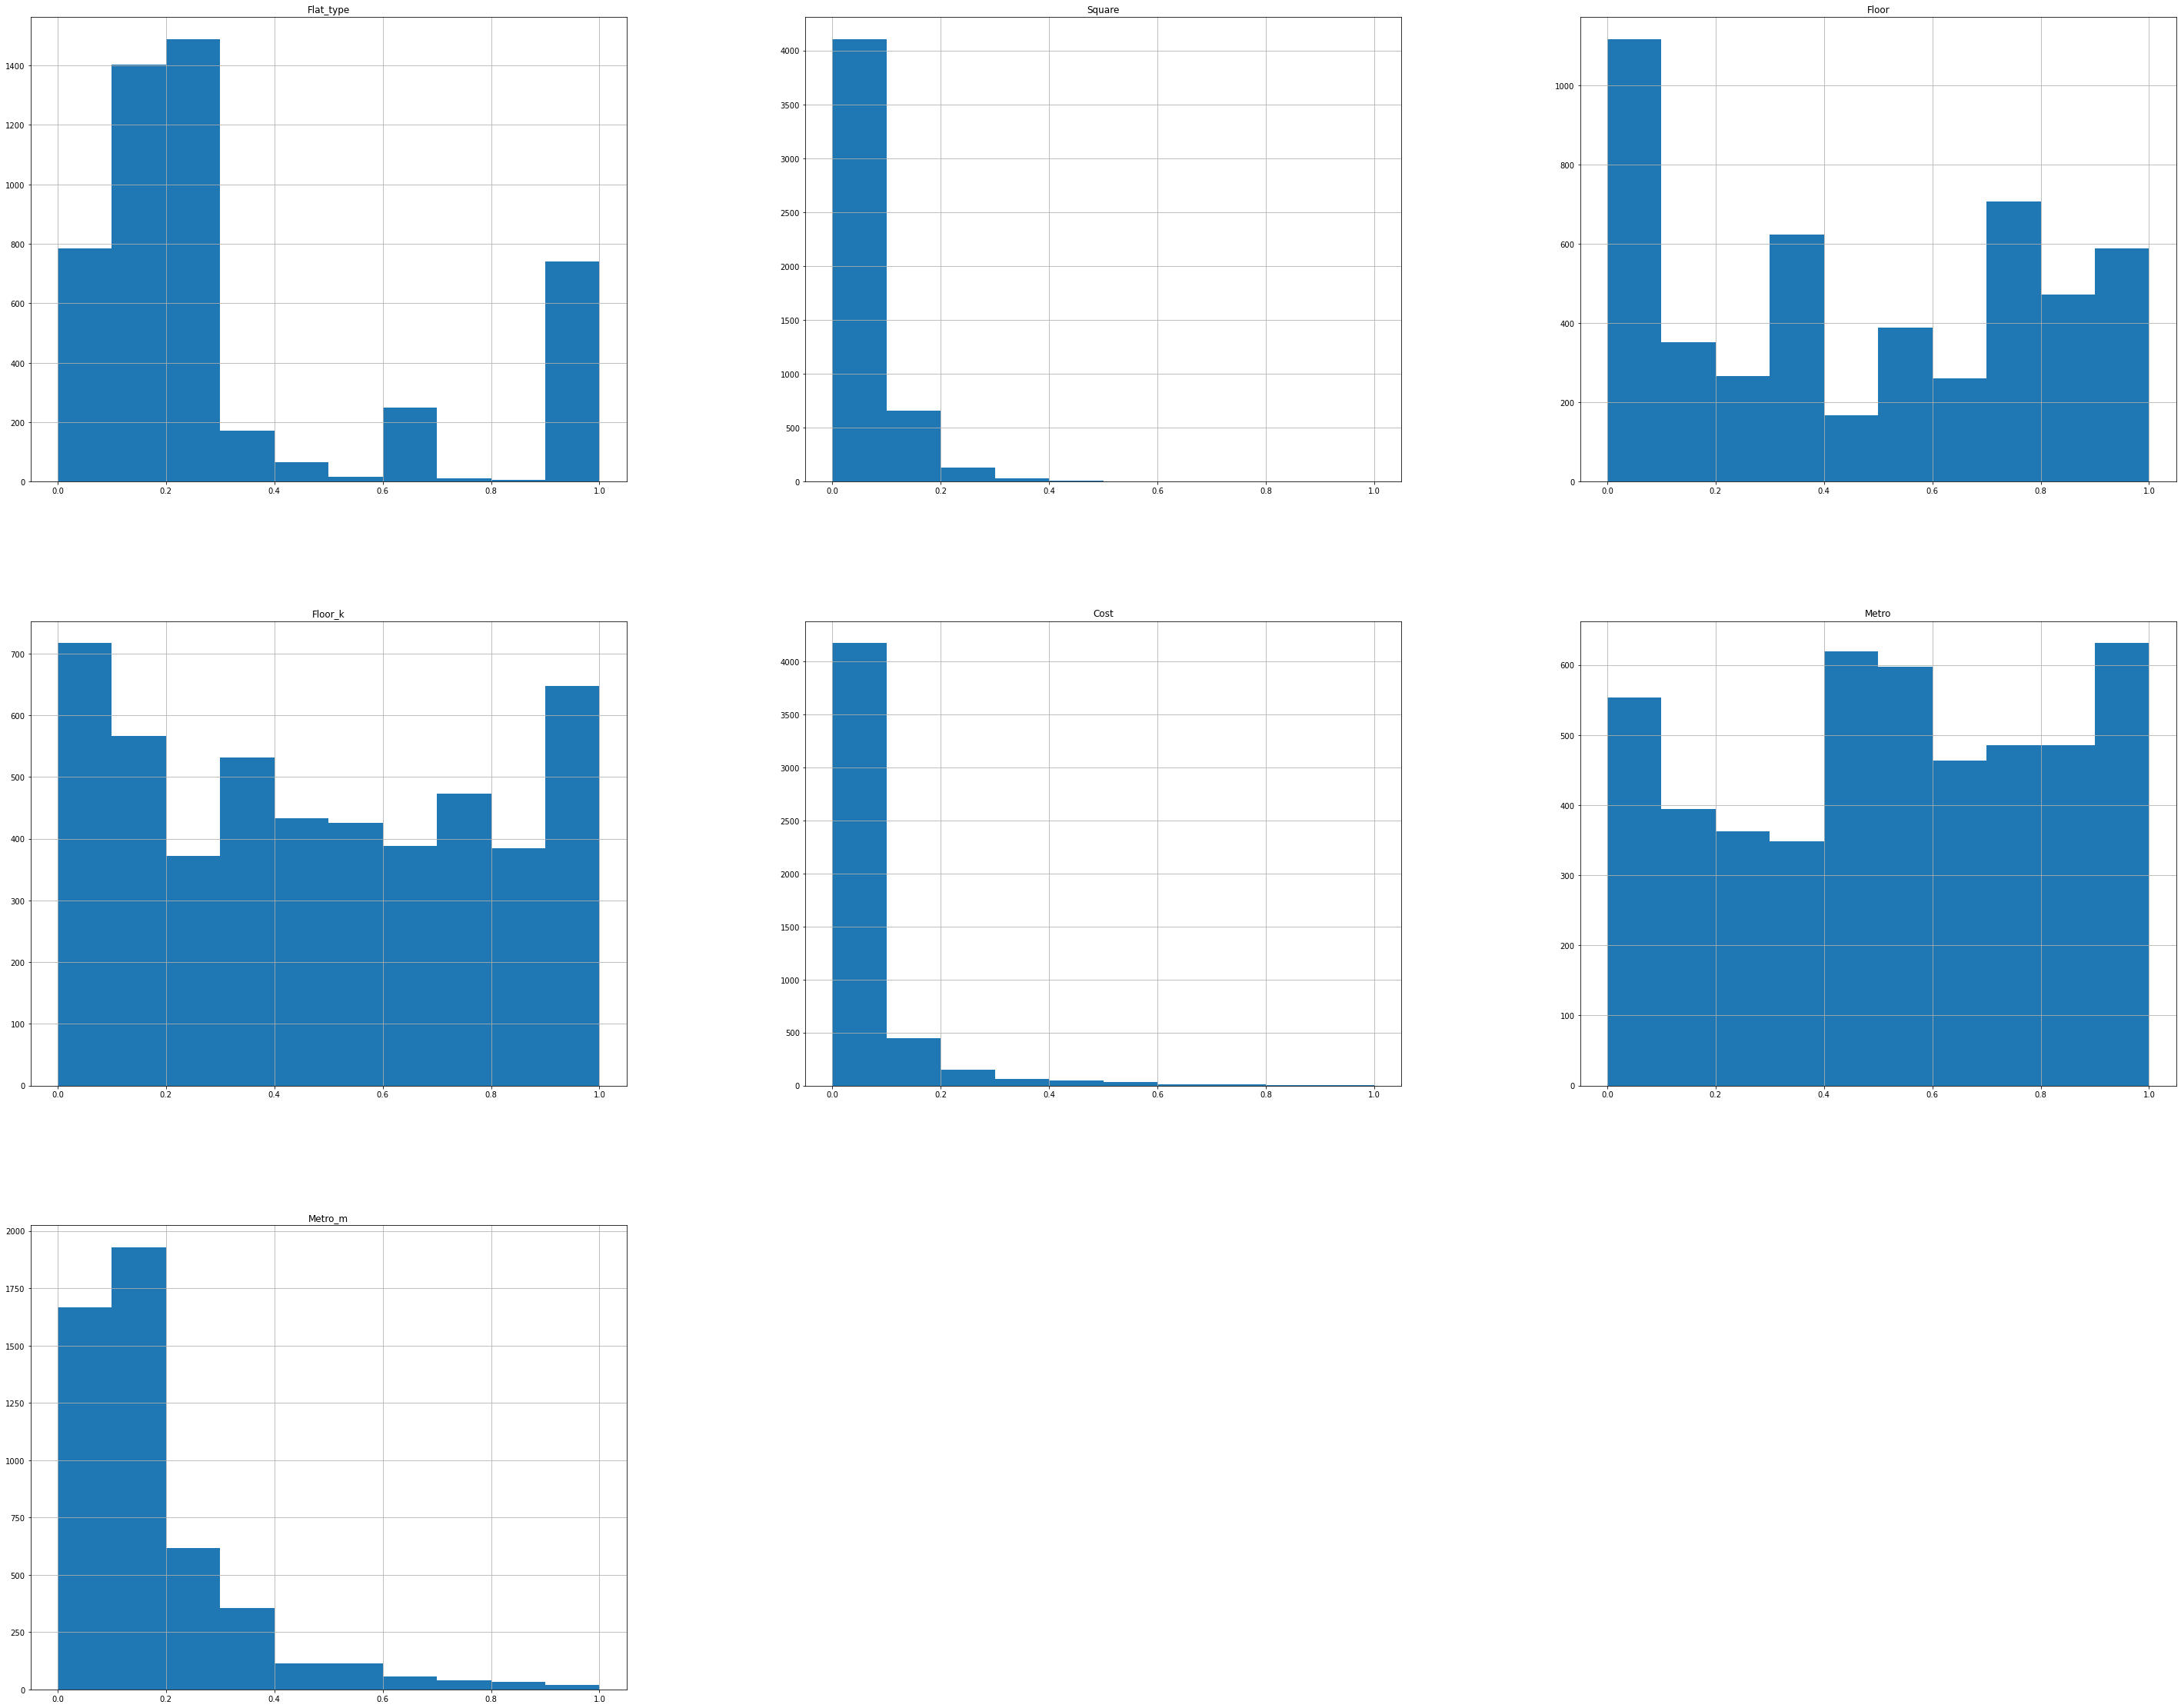

In [137]:
#Гистограммы датасета
#Можно заметить сильную скошенность у графиков по площади и цене
df.hist(figsize=(50, 40))

In [268]:
corr_table = df.corr()
corr_table
#Согласно шкале Шеддока, сила связи между стоимостью и площадью - умеренная, между стоимостью и остальными показателями - слабая

,Flat_type,Square,Floor,Floor_k,Cost,Metro,Metro_m
Flat_type,1.000000,-0.298866,-0.400115,-0.368371,-0.291551,-0.015901,-0.003516
Square,-0.298866,1.000000,0.189515,0.210433,0.680177,0.024613,-0.084041
Floor,-0.400115,0.189515,1.000000,0.316547,0.155928,-0.004336,-0.020702
Floor_k,-0.368371,0.210433,0.316547,1.000000,0.195712,0.029042,-0.043889
Cost,-0.291551,0.680177,0.155928,0.195712,1.000000,0.066317,-0.216122
Metro,-0.015901,0.024613,-0.004336,0.029042,0.066317,1.000000,-0.012367
Metro_m,-0.003516,-0.084041,-0.020702,-0.043889,-0.216122,-0.012367,1.000000


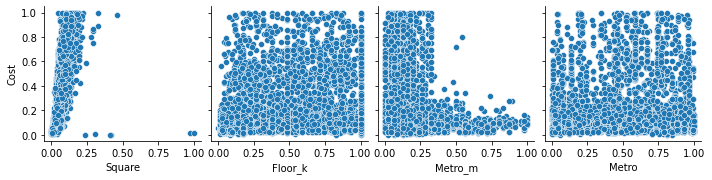

In [267]:
import seaborn as sns
sns.pairplot(data=df,
                  y_vars=['Cost'],
                  x_vars=['Square', 'Floor_k', 'Metro_m', 'Metro'])

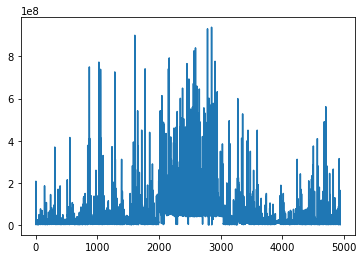

In [257]:
import matplotlib.pyplot as plt

# using only data attribute
plt.plot(df['Cost'])
plt.show()

<AxesSubplot:xlabel='Cost'>

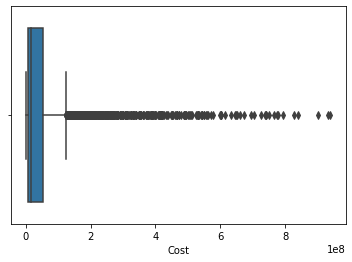

In [258]:
sns.boxplot(x='Cost', data=df)

128
3.0217186024551466%


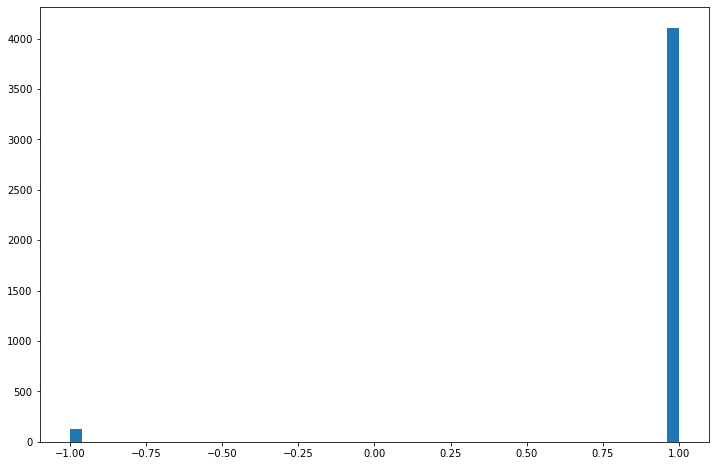

In [265]:
from numpy import where
import matplotlib.pyplot as plt
#128 записей являются выбросами
IF = IsolationForest(n_estimators=100, contamination=.03)
predictions = IF.fit_predict(df)
plt.figure(figsize=(12, 8))
plt.hist(predictions, bins=50)
anom_count = 0
for i in predictions:
    if(i == -1):
        anom_count += 1
print(anom_count)
print(f'{anom_count/len(predictions) * 100}%')

In [261]:
#В результате визуального анализа было принято решении об удалении записей объявлений со стоимостью выше 100 миллионов рублей
df[(df['Cost']>100000000)] = np.nan
df = df.dropna()

In [266]:
#Для выравнивания показателей и избавления от выбросов была проведена нормализация данных
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
names = df.columns
d = scaler.fit_transform(df)

df = pd.DataFrame(d, columns=names)

## Обучение моделей
В случае данного набора данных предполагается прогнозирование стоимости квартиры на основе показателей площади квартиры, коэффициента этажа, ближайшей станции метро, удаленности от ближайшей станции метро, типа квартиры.
Предполагается решение задача регрессии

In [269]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.linear_model import (LinearRegression, ElasticNet, BayesianRidge)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)


In [270]:
X = df.drop(columns=['Cost', 'Floor'])
y = df['Cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def learn(model, *args, **kwargs):
    model = model(*args, **kwargs)
    model.fit(X_train, y_train)
    res = {}
    res['name'] = model.__class__.__name__
    res['r2_train'] = r2(y_train, model.predict(X_train))
    res['r2_test'] = r2(y_test, model.predict(X_test))
    res['mse_train'] = mse(y_train, model.predict(X_train)) ** 0.5
    res['mse_test'] = mse(y_test, model.predict(X_test)) ** 0.5
    res['mae_train'] = mean_absolute_error(y_train, model.predict(X_train)) 
    res['mae_test'] = mean_absolute_error(y_test, model.predict(X_test)) 
    res['params'] = kwargs
    return res
def learn_multiple_models(models):
    return pd.DataFrame([learn(model) for model in models])
models = [BayesianRidge, LinearRegression, Ridge, RidgeCV, LassoCV, RandomForestRegressor, GradientBoostingRegressor]
learn_multiple_models(models)

,name,r2_train,r2_test,mse_train,mse_test,mae_train,mae_test,params
0,BayesianRidge,0.540527,0.290347,0.160763,0.185976,0.100264,0.102119,{}
1,LinearRegression,0.540528,0.289587,0.160763,0.186076,0.100200,0.102072,{}
2,Ridge,0.531975,0.341673,0.162253,0.179125,0.106452,0.107221,{}
3,RidgeCV,0.531975,0.341673,0.162253,0.179125,0.106452,0.107221,{}
4,LassoCV,0.537354,0.324233,0.161318,0.181482,0.103269,0.104066,{}
5,RandomForestRegressor,0.973186,0.798091,0.038837,0.099200,0.021400,0.058298,{}
6,GradientBoostingRegressor,0.856653,0.803380,0.089795,0.097892,0.055484,0.061050,{}


## Поиск оптимальных гиперпараметров и кросс-валидация
Наилучшими по показателям коэффициента детерминации и средним ошибкам оказались модели RandomForestRegressor и GradientBoostingRegressor
Был произведен поиск оптимальных гиперпараметров через случайный GridSearch (для случайного леса), GridSearch (для градиентного бустинга) и кросс-валидация выборок

In [272]:
#Для случайного леса
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [215]:
%%time
#Для градиентного бустинга
parameters_gbr = { 
                 "learning_rate": np.arange(0.1, 500.1, 100.0),
                 "n_estimators" :  range(50, 100, 10),
                 "subsample": np.arange(0.1, 1.0, 0.1),
                }
gbr = GradientBoostingRegressor()
grid_gbr = GridSearchCV(gbr, parameters_gbr)
grid_gbr.fit(X_train, y_train)
grid_gbr.best_params_

C:\Users\User\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\User\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\User\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarning: overflow encountered in square
  sample_weight * ((y - raw_predictions.ravel()) ** 2)))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:691: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\User\anaconda3\lib\site-packages\sklearn\ensemble\_gb_losses.py:202: RuntimeWarnin

Wall time: 28.7 s


{'learning_rate': 0.1, 'n_estimators': 90}

In [273]:
learn(RandomForestRegressor, **rf_random.best_params_)

{'name': 'RandomForestRegressor',
 'r2_train': 0.9772045119424908,
 'r2_test': 0.8129622805721688,
 'mse_train': 0.03580811864620898,
 'mse_test': 0.09547712089719214,
 'mae_train': 0.020040649739018604,
 'mae_test': 0.05535960726787947,
 'params': {'n_estimators': 1000,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 110,
  'bootstrap': True}}

In [274]:
learn(GradientBoostingRegressor, **grid_gbr.best_params_)

{'name': 'GradientBoostingRegressor',
 'r2_train': 0.8514650750505002,
 'r2_test': 0.8021914616269673,
 'mse_train': 0.09140529337407544,
 'mse_test': 0.0981877328173188,
 'mae_train': 0.05650144923320114,
 'mae_test': 0.061584207872089215,
 'params': {'learning_rate': 0.1, 'n_estimators': 90}}

Оптимальные параметры дали незначительный прирост коэффициенту детерминации моделям: 2% случайному лесу и 0.01% градиентному бустингу соответственно

In [276]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
train_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=10)
test_scores = cross_val_score(model, X_test, y_test, scoring='r2', cv=10)


In [281]:
print('r2_train_cross_val = ' + str(np.mean(train_scores)) + ', r2_test_cross_val = ' + str(np.mean(test_scores)))

r2_train_cross_val = 0.8099158449074573, r2_test_cross_val = 0.7432201756359401


Модель RandomForestRegressor показывает следующие результаты: коэффициент детерминации равняется 0.81, что характеризует функциональную связь модели как высокую (по шкале Чеддока для множественной детерминации).
Однако, при проведении кросс-валидации среднее значение коэффициента падает, что указывает на небольшую неустойчивость модели
В целом, модель можно описать, как устойчивую и хорошо описывающую набор данных